[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tuankhoin/COMP30027-Practical-Solutions/blob/main/2022/Week%212.ipynb)

#### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Week 12 - Unsupervised Methods

Today, we are talking about Unsupervised Machine Learning Methods.

We are going to implement and evaluate some clustring methods using k-Means, GMM and KDE.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

from sklearn.model_selection import train_test_split

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity

### Exercise 1. 
In this section, we'll write a function to generate a synthetic data set with Normal distributions.
Later on, we'll try to fit k-Means and GMM to the synthetic data set and see how well we can recover our predifiend parameters.

We'll store our predifined parameters (to develop our synthetic data) in NumPy arrays as follows. Note: the zero-th axis indexes the component $c$ for all arrays.
* `weights`: a 1D array $[w_1, \ldots, w_k]$
* `means`: a 2D array $[\mathbf{\mu}_1, \ldots, \mathbf{\mu}_k]$
* `covariances`: a 3D array $[\mathbf{\sigma}_1, \ldots, \mathbf{\sigma}_k]$

Below are some example parameters for a 2D feature space ($m = 2$) with $k = 3$ components. Note that the covariance matrices must be symmetric positive semi-definite. Thus each covariance matrix only has 3 degrees of freedom (for $m = 2$).

In [ ]:
weights = np.array([0.5, 0.3, 0.2])

means = np.array([[0, 0],    # mean of 1st component
                  [50, 60],  # mean of 2nd component
                  [0, 100]]) # mean of 3rd component

covariances = np.array([[[160, 20], [20, 180]],  # covariance matrix of 1st component
                        [[170, 30], [30, 120]],  # covariance matrix of 2nd component 
                        [[130, 40], [40, 130]]]) # covariance matrix of 3rd component


#### Exercise 1. (a)
Complete the data generation function below.

In [ ]:
def generate_data(n_instances, weights, means, covariances):
    """
    Generate data from a GMM
    
    Arguments
    =========
    n_instances : int
        number of instances in the generated data set
    weights : numpy array, shape: (n_components,)
        normalised component weights
    means : numpy array, shape (n_components, n_features)
        component means
    covariances : numpy array, shape (n_components, n_features, n_features)
        component covariance matrices
    
    Returns
    =======
    numpy array, shape (n_instances, n_features)
        data matrix
    """
    n_components, n_features = means.shape
    data = np.empty((0, n_features), dtype=np.double)
    
    # Draw number of instances in each component
    counts = np.random.multinomial(n_instances, weights) # fill in
    
    for c in range(0, n_components):
        # Draw x_i's for this component
        cData = np.random.multivariate_normal(means[c], covariances[c], counts[c]) # fill in
        
        # Append to data
        data = np.vstack((data, cData)) # fill in
    
    return data

Let's try it.

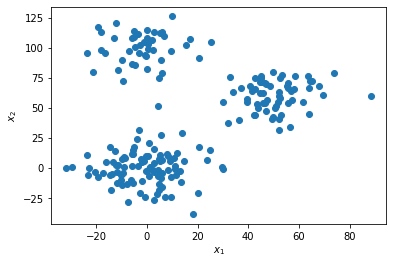

In [ ]:
data = generate_data(200, weights, means, covariances)

plt.scatter(data[:,0], data[:,1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

#### Exercise 1. (b)
Use the method of k-means to cluster this data. Show the Centroids. Are they close to our predefined parameters?

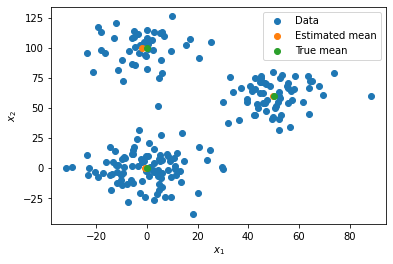

cluster centers:
 [[ -0.71249331  -0.41325236]
 [ -1.85521695 100.10511047]
 [ 49.79179506  60.04459614]]


In [ ]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(data)

plt.scatter(data[:,0], data[:,1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

centers = km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1])
plt.scatter(means[:,0],means[:,1])
plt.legend(['Data','Estimated mean','True mean'])
plt.show()

print('cluster centers:\n', centers)

#### Exercise 1. (c)
Now use the GMM method to cluster this data. Show the mean and Standard Deviations. Are they close to our predefined parameters?

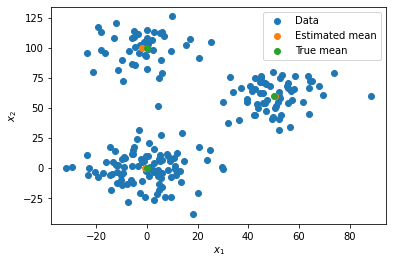

weights:
 [0.22145174 0.46833584 0.31021242]

means:
 [[-1.81320648e+00  9.97844205e+01]
 [-6.73429090e-01 -4.37098514e-02]
 [ 5.04876206e+01  6.01782697e+01]]

covariances:
 [[[114.4663002   11.56450852]
  [ 11.56450852 170.78886603]]

 [[150.38311047   2.38278941]
  [  2.38278941 191.11134724]]

 [[112.19096805  21.45479823]
  [ 21.45479823 150.57825686]]]



In [ ]:
num_clusters = 3

gmm = GaussianMixture(n_components=num_clusters, covariance_type='full')
gmm.fit(data)

plt.scatter(data[:,0], data[:,1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])
plt.scatter(means[:,0],means[:,1])
plt.legend(['Data','Estimated mean','True mean'])
plt.show()

print('weights:\n {}\n'.format(gmm.weights_))
print('means:\n {}\n'.format(gmm.means_))
print('covariances:\n {}\n'.format(gmm.covariances_))

### Exercise 2. 
For 2D data, we can also visualise the fitted model. 
The 2D Gaussians can be represented with isoline ellipsoids. 
For each Gaussian component, the ellipsoid is a location of points that have the same probability. 

Plotting an ellipsoid for a given 2D Gaussian, is somewhat non-trivial, and we are going to use a function developed for this purpose. 
Understanding the code and theory of function *plot_cov_ellipse* is not necessary for this workshop. 

In [ ]:
# adapted from http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/
# and https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, fc='none', ec=[0,0,0], a=1, lw=2):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':a, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)

    ax.add_artist(ellip)
    return ellip

#### Exercise 2.(a)
Using the above function, implement visualisation that plots data overlaid with fitted Gaussian ellipsoids.

In [ ]:
def plot_gmm(data, gmm, ax=None):
    """
    data : numpy array, shape: (n_instances, n_features)
        data matrix
    
    gmm : GaussianMixture
        GaussianMixture instance to use for predictions/plotting
    """
    # your code here #
    if ax is None: _,ax=plt.subplots(1,1)
    ax.scatter(data[:,0], data[:,1], c=gmm.predict(data))
    for c in range(gmm.n_components):
        plot_cov_ellipse(gmm.covariances_[c], gmm.means_[c],ax=ax)

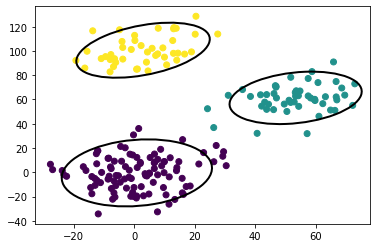

In [ ]:
plot_gmm(data, gmm)

#### Exercise 2.(b)
Let's see what happens if we specify the "wrong" number of clusters. Use GMM to divide the data in 2, 5 and 9 clusters and illustrate the results. What is the problem?

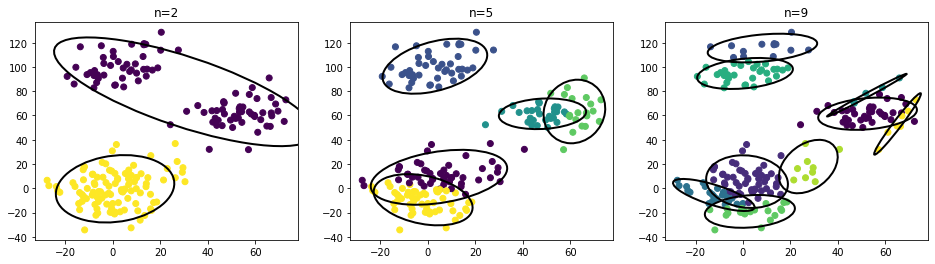

In [ ]:
ns = [2,5,9]
_, ax_gmm = plt.subplots(1,len(ns),figsize=(16,4))
for i,n in enumerate(ns):
  gmm = GaussianMixture(n_components=n, covariance_type='full').fit(data)
  plot_gmm(data, gmm, ax_gmm[i])
  ax_gmm[i].set_title(f'n={n}')

### Exercise 3.
In the previous section, we saw that it's important to select an appropriate value for $k$—i.e. GMM is not reslient to misspecified $k$.
But how we can find the "correct" k in a realistic situation (when the data is not synthetic).


#### Exercise 3.(a)
Use **Log-likelihood** for selecting $k$. Log-likelihood of GMM can be computed for a data matrix `X` using `gmm.score(X)`.

For this task we need to divide our data to train and evaluation datasets (why?).


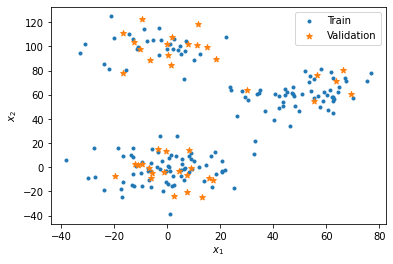

In [ ]:
data = generate_data(200, weights, means, covariances)

train_data, validation_data = train_test_split(data, test_size=0.2)

plt.scatter(train_data[:,0], train_data[:,1], marker='.', label='Train')
plt.scatter(validation_data[:,0], validation_data[:,1], marker='*', label='Validation')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

Then we fit a GMM for each value of $k \in \{1,\ldots, 10\}$ and compute:
* `train_ll`: log-likelihood on the training set
* `validation_ll`: log-likelihood on the validation set

In [ ]:
def gmm_score(rng,data):
    
    print(data.shape)
    range_k = np.arange(1, rng, dtype=int)
    n_instances = data.shape[0]
    
    print(range_k.size)

    # Arrays to hold quantities for each k
    train_ll = np.zeros(range_k.size)
    validation_ll = np.zeros(range_k.size)
  
    for i,k in enumerate(range_k):
        gmm_cv = GaussianMixture(n_components=k, covariance_type='full').fit(train_data)
        train_ll[i] = gmm_cv.score(train_data)
        validation_ll[i] = gmm_cv.score(validation_data)
    
    return range_k, train_ll, validation_ll

(200, 2)
9


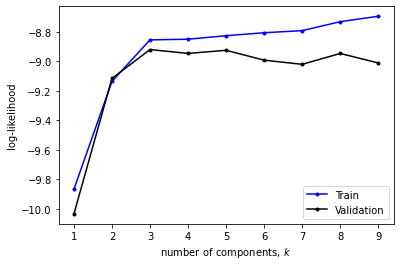

In [ ]:
rng = 10
range_k, train_ll, validation_ll = gmm_score(rng,data)

plt.plot(range_k, train_ll, 'b.-', label = 'Train')
plt.plot(range_k, validation_ll, 'k.-', label = 'Validation')
plt.xlabel('number of components, $k$')
plt.ylabel('log-likelihood')
plt.legend()
plt.show()

#### Exercise 3.(b)
What is the best K based on the above diagram? Is it compatible with our predifined parameters? 

Train data will keep increasing, even though little, so of course it will overfit with itself. To see the efficiency you need a validation dataset.

And if you look at the plot, then now it makes more sense: log-likelihood stops increasing after k=3.

#### Exercise 3.(c)
Let's try it again with a different dataset.

In [ ]:
weights = np.array([0.3, 0.2, 0.3, 0.1, 0.1])

means = np.array([[0, 0], 
                  [50, 60], 
                  [0, 100], 
                  [100, -20], 
                  [-20, 40]])

covariances = np.array([[[160, 20], [20, 180]], 
                        [[170, 30], [30, 120]], 
                        [[130, 40], [40, 130]], 
                        [[130, 40], [40, 130]], 
                        [[130, 40], [40, 130]]])

data = generate_data(200, weights, means, covariances)

train_data, validation_data = train_test_split(data, test_size=0.2)


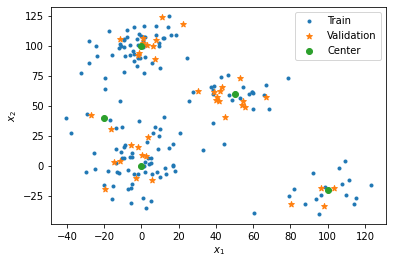

In [ ]:
plt.scatter(train_data[:,0], train_data[:,1], marker='.', label='Train')
plt.scatter(validation_data[:,0], validation_data[:,1], marker='*', label='Validation')
plt.scatter(means[:,0],means[:,1],label='Center')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

(200, 2)
9


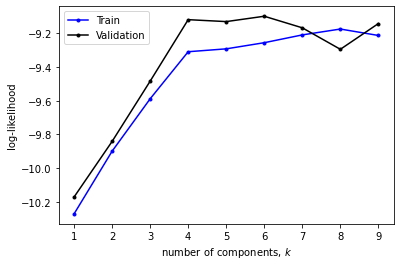

In [ ]:
rng = 10
range_k, train_ll, validation_ll = gmm_score(rng,data)

plt.plot(range_k, train_ll, 'b.-', label = 'Train')
plt.plot(range_k, validation_ll, 'k.-', label = 'Validation')
plt.xlabel('number of components, $k$')
plt.ylabel('log-likelihood')
plt.legend()
plt.show()

#### Exercise 3.(d)
Analyse the resulting plots. What can you tell about the number of parameters? Can all of these quantities be used to estimate the number of clusters?

## Exercise 4.

### Exercise 4.(b)

Do kernel density estimation on the synthetic data.

In [ ]:
kde = KernelDensity(kernel='gaussian', bandwidth=10)
kde.fit(train_data)

KernelDensity(bandwidth=10)

In [ ]:
# draw figure (heatmap or isocontours)
def drawPDF(pdf, xlim, ylim, multiple=None):
    fig, ax = plt.subplots(2, len(pdf) if multiple else 1, figsize=(len(pdf)*4+4,8) if multiple else (5,8))
    
    if not multiple:
      ax[0].imshow(pdf,
          origin='lower', aspect='auto',
          extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
          cmap='Reds')
      ax[0].scatter(train_data[:,0], train_data[:,1], marker='.')
      ax[0].set_xlabel('$x_1$')
      ax[0].set_ylabel('$x_2$')

      levels = np.linspace(0, pdf.max(), 5)
      ax[1].contour(Xgrid, Ygrid, pdf,
          origin='lower',
          colors='black')
      ax[1].scatter(train_data[:,0], train_data[:,1], marker='.')
      ax[1].set_xlabel('$x_1$')
      ax[1].set_ylabel('$x_2$')
    else:
      for i,p in enumerate(pdf):
        ax[0,i].imshow(p,
          origin='lower', aspect='auto',
          extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
          cmap='Reds')
        ax[0,i].scatter(train_data[:,0], train_data[:,1], marker='.')
        ax[0,i].set_xlabel('$x_1$')
        ax[0,i].set_ylabel('$x_2$')
        ax[0,i].set_title(f'Bandwidth = {multiple[i] if multiple else 10}')

        levels = np.linspace(0, p.max(), 5)
        ax[1,i].contour(Xgrid, Ygrid, p,
            origin='lower',
            colors='black')
        ax[1,i].scatter(train_data[:,0], train_data[:,1], marker='.')
        ax[1,i].set_xlabel('$x_1$')
        ax[1,i].set_ylabel('$x_2$')
    plt.show()

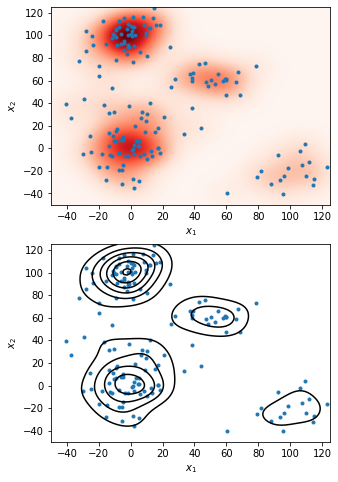

In [ ]:
# sample points on a regular grid to show the distribution
xlim = np.array([-50,125])
ylim = np.array([-50,125])
Xgrid, Ygrid = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
samples = np.vstack([Xgrid.ravel(), Ygrid.ravel()])
samples = np.transpose(samples)

# probability estimate at the sample points
pdf = np.exp(kde.score_samples(samples))
pdf = np.reshape(np.transpose(pdf), Xgrid.shape)
drawPDF(pdf, xlim, ylim)

### Exercise 4.(b)

The kernel bandwidth is a free parameter that affects the smoothness of the probability distribution. What bandwidth range will produce 4 separate peaks corresponding to the 4 clusters? What happens if you increase or decrease the bandwidth beyond this range?

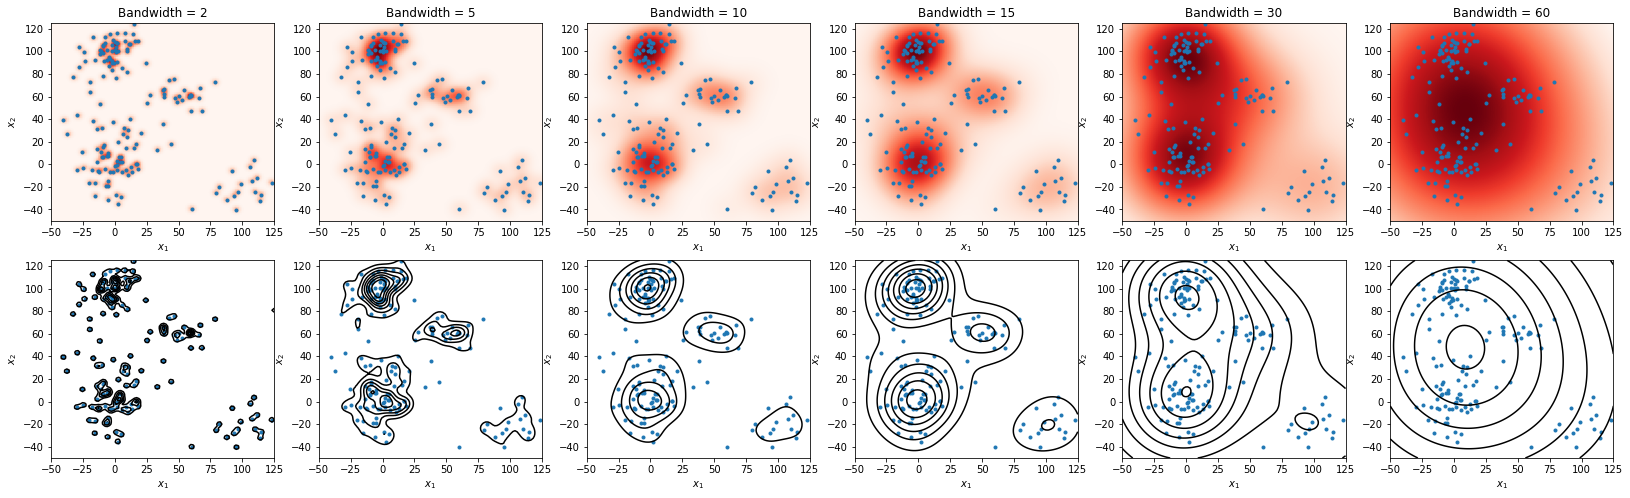

In [ ]:
pdf = []
bws = [2,5,10,15,30,60]

for b in bws:
  kde = KernelDensity(kernel='gaussian', bandwidth=b)
  kde.fit(train_data)
  single_pdf = np.exp(kde.score_samples(samples))
  pdf.append(np.reshape(np.transpose(single_pdf), Xgrid.shape))
drawPDF(pdf, xlim, ylim, bws)

## That's all. Good luck for the upcoming exams!

To end the sem meaningfully, get on the beers with your class 🍺 Feels good to come back from lockdown!